# Shapley Values for Machine Learning

In this notebook, we'll cover an approximate method for computing Shapley Values. This approach is much more appropriate for analyzing machine learning models. The method covered here is based off of the one described in *Strumbelj et al. (2014)*.

## Motivation

In my YouTube video entitled *Introduction to Shapley Values*, I covered the classic definition of these quantities, originally developed within the context of Game Theory. Shapley Values provided a powerful means by which we can assess how important a given input feature is, to the output of any predictive machine learning model. As a result, Shapley Values are an extremely important component to developing explainable AI solutions. You can watch that video here: https://www.youtube.com/watch?v=kEi6OEsjInQ.

The following shortcomings were covered in terms of the classic Shapley Value definition, at the end of that aforementioned video:
1. As the number of input features increases, the number of computational iterations becomes exponentially larger
2. Retraining our model for each value function call isn't very sensible: many models will not function on just a subset of features, and the training times can be quite long!

Both of these points make the classic Shapley Value unusable in a practical, machine learning context. As such, what we need is to develop a numerical technique that will deliver approximate Shapley Values, that will also get around the two issues raised above. 

## Approximate Shapley Values

The Shapley Value $\phi_i$, for one feature $i$ out of all available input features, is approximately given by:

$$\phi_i = \frac{1}{M}\sum_{m=1}^M f(x^m_{+i}) - f(x^m_{-i}) = \frac{1}{M}\sum_{m=1}^M \phi^m_i$$

where:
* $f$ is the predictive model
* $M$ is an integer number of iterations we can pick
* $x^m_{+i}$ is a *constructed sample* that **includes** the original value for feature $i$
* $x^m_{-i}$ is a *constructed sample* that **replaces** the original value for feature $i$

To shed more light on this, let's now cover the procedure to compute $\phi_i$, step-by-step:
1. Select a value for $M$, $i$, and a sample of interest $x$ from the available input predictive dataset $X$. Note $X$ does not include labels/targets
2. for $m=1..M$:
    1. draw a random sample $z$ from $X$
    2. compute a random ordering $o$ of the set of features in $X$
    3. reorder the features in samples $x$ and $z$ according to $o$, $\implies x^o$ and $z^o$
    4. construct sample $x^m_{+i} = (x^o_1, ..., x^o_{i-1}, x^o_{i}, z^o_{i+1}, ..., z^o_F)$
    5. construct sample $x^m_{-i} = (x^o_1, ..., x^o_{i-1}, z^o_{i}, z^o_{i+1}, ..., z^o_F)$
    6. compute $\phi^m_i = f(x^m_{+i}) - f(x^m_{-i})$, and save this value
3. Compute $\phi_i = \frac{1}{M}\sum_{m=1}^M \phi^m_i$

Note: 
* the exercise of reordering samples $x$ and $z$, according to $o$, is done as a means to compute different permutations of the input features (see steps B through E).
* in steps D and E, the superscript indicates the features are ordered according to $o$, whereas the subscript shows the index position according to $o$. $F$ is the total integer number of features in $X$.
* in step F, the constructed samples are reordered back to the original feature arrangement (so they can be input to the model $f$). 

## Worked Python Example

Let's now work through an example, to make these concepts tangible:

In [1]:
# imports
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

In [2]:
# create a simple regression dataset
X, y = make_regression(n_samples=10, n_features=3, noise=1, random_state=42)

In [3]:
X

array([[ 0.76743473,  1.57921282, -0.46947439],
       [-0.23415337,  1.52302986, -0.23413696],
       [ 0.11092259, -0.54438272, -1.15099358],
       [-0.60063869,  0.37569802, -0.29169375],
       [-1.91328024,  0.24196227, -1.72491783],
       [-1.01283112, -0.56228753,  0.31424733],
       [-0.1382643 ,  0.49671415,  0.64768854],
       [-0.46341769,  0.54256004, -0.46572975],
       [-1.4123037 , -0.90802408,  1.46564877],
       [ 0.0675282 , -0.2257763 , -1.42474819]])

In [4]:
y

array([ 135.87495442,   91.04151968,  -46.19406261,   -3.4087805 ,
        -89.97336122,  -78.12657288,   35.27171292,   11.43196996,
       -103.62807383,  -28.66982502])

In [5]:
# scale the input predictor features
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [6]:
# declare a model instance and train it
model = LinearRegression()
model.fit(X,y)

LinearRegression()

In [7]:
def construct_sample(x: np.array, z: np.array, i: int, plus: bool) -> np.array:
    """
    Function to construct a sample based on x and z
    """
    # assemble sample
    out = []
    for j in range(x.shape[0]):
        if j < (i + int(plus)):
            out.append(x[j])
        else:
            out.append(z[j])
    # return the correctly formatted sample
    return np.array(out).flatten()

In [8]:
def reverse_ordering(o: list, dims: int) -> list:
    """
    Function to reverse shuffling for input into the model
    """
    reversed_o = []
    for j in range(dims):
        reversed_o.append(o.index(j))
    return reversed_o

In [9]:
def approx_shapley(x: np.array, i: int, M: int, X: np.array, model: object) -> float:
    """
    Function to compute the approximate Shapley value for a sample of interest x, and feature i
    """
    phi_i = 0
    o = [f for f in range(X.shape[1])]
    for m in range(M):
        # select sample z
        z_id = random.sample(range(0, X.shape[0]-1), 1)[0]
        z = X[z_id, :]
        # randomly shuffle ordering of features
        random.shuffle(o)
        # reorder samples
        x_o = np.copy(x[o])
        z_o = np.copy(z[o])
        # construct new samples
        x_plus = construct_sample(x_o, z_o, o.index(i), plus=True)
        x_minus = construct_sample(x_o, z_o, o.index(i), plus=False)
        # compute the mth contribution to phi
        f_plus = model.predict(x_plus[reverse_ordering(o, X.shape[1])].reshape(1,-1))[0]
        f_minus = model.predict(x_minus[reverse_ordering(o, X.shape[1])].reshape(1,-1))[0]
        phi_i += (f_plus - f_minus)
    # return the normalized phi
    return phi_i/M

We can manually work through the calculations for a single sample in detail:

In [10]:
# obtain a sample
x_1 = X[1,:]

In [11]:
# set the number of iterations to run the calculation
M = 100

In [12]:
# shapley value for feature 0
s_0 = approx_shapley(x_1, 0, M, X, model)
s_0

17.73435415884023

In [13]:
# shapley value for feature 1
s_1 = approx_shapley(x_1, 1, M, X, model)
s_1

74.42202510769383

In [14]:
# shapley value for feature 2
s_2 = approx_shapley(x_1, 2, M, X, model)
s_2

-0.45146224172493743

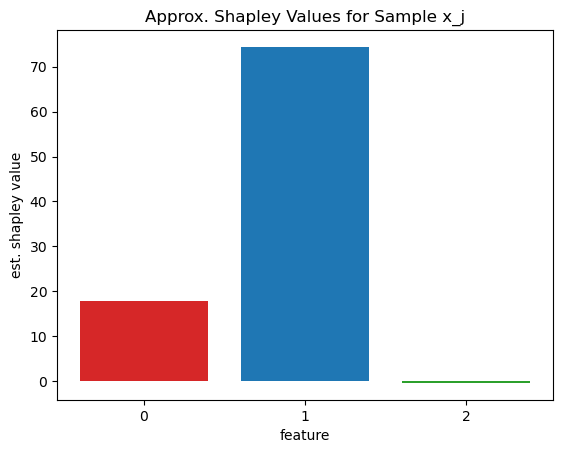

In [15]:
# plot the feature shapley values for x_j
fig, ax = plt.subplots()

features = ['0', '1', '2']
values = [s_0, s_1, s_2]
bar_colors = ['tab:red', 'tab:blue', 'tab:green']

ax.bar(features, values, color=bar_colors)
ax.set_xlabel('feature')
ax.set_ylabel('est. shapley value')
ax.set_title('Approx. Shapley Values for Sample x_j')

plt.show()

What are the expected Shapley Values for all samples in $X$? And how do these compare with our model parameters?

In [16]:
results = {0:[],1:[],2:[]}
for j in range(X.shape[0]):
    x_j = X[j,:]
    for i in range(X.shape[1]):
        results[i].append(approx_shapley(x_j, i, M, X, model))

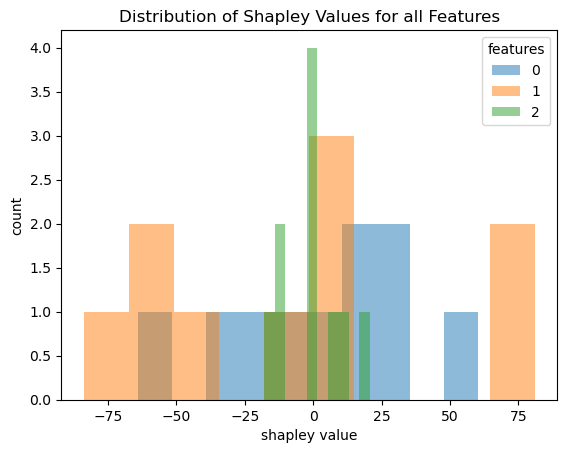

In [17]:
plt.hist(results[0], alpha=0.5, bins=10, label='0')
plt.hist(results[1], alpha=0.5, bins=10, label='1')
plt.hist(results[2], alpha=0.5, bins=10, label='2')
plt.xlabel('shapley value')
plt.ylabel('count')
plt.title('Distribution of Shapley Values for all Features')
plt.legend(title='features')
plt.show()

In [18]:
model.fit(X,y)
model.coef_

array([33.17695477, 54.12190107, 11.73925815])

## Concluding Remarks

The above results demonstrate that our implementation works, and the results that we get are consistent with our inituition for this linear model. In other words, features with larger model coefficients tend to be allocated larger absolute shapley values. Note that the calculation of the Shapley Value is completely model agnostic. 

In addition, it is important to note that we have overcome the limitations of using the classic Shapley Value definition. No model retraining was required, and we control the number of iterations our model runs through the parameter $M$. As such, it is this approach that is much more suitable for analyzing machine learning applications! 